In [ ]:
# Nate Brunacini, nbrunaci@u.rochester.edu
# Supervisor: Kelly A. Douglass
# This file includes methods to find the gradient (slope of the trend line) of the N2, O3N2, and N2O2 metallicities of 
# each spaxel in a MaNGA galaxy and to create a scatter plot of those gradient values.

In [1]:
# Import packages
from astropy.io import fits
import deproject_spaxel as dps
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.table import Table
from scipy.stats import linregress

import marvin
from marvin.tools.maps import Maps

/home/nbrunaci/.local/lib/python3.9/site-packages/marvin/core/exceptions.py:50: UserWarning: cannot initiate Sentry error reporting: [Errno 6] No such device or address.
  warnings.warn('cannot initiate Sentry error reporting: {0}.'.format(str(ee)),
[INFO]: No release version set. Setting default to DR15
[WARNING]: path /home/nbrunaci/sas/mangawork/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /home/nbrunaci/sas/mangawork/manga/spectro/analysis/v2_4_3/2.2.1/dapall-v2_4_3-2.2.1.fits cannot be found. Setting dapall to None. (MarvinUserWarning)


In [2]:
# Takes in plateifu and table of kinematic center data, returns coordinates of kinematic center of galaxy
def getKinematicCenter(plateifu,c_table):
    plate, ifu = plateifu.split('-')
    bool_index = np.logical_and(c_table['MaNGA_plate'] == int(plate), c_table['MaNGA_IFU'] == int(ifu))
    x_coord = c_table['x0_map'][bool_index].data[0]
    y_coord = c_table['y0_map'][bool_index].data[0]
    return (y_coord,x_coord)
    
# x0_map,y0_map: pass in as (y,x); same as (row,column)

# Returns coordinates of photometric center of the galaxy with the given plateifu
def getPhotometricCenter(plateifu):
    maps = Maps(plateifu)
#     print(maps.datamodel)
    gfluxmap = maps['spx_mflux']
    center = np.unravel_index(np.argmax(gfluxmap.data),gfluxmap.shape)
    return center

In [3]:
# Takes in plateifu, data from drpall file, and table of kinematic centers, generates lists of normalized radius from galactic center and metallicity values, and outputs them in a dictionary
def radius_lists(plateifu,drp,c_table):
    with fits.open('MetallicityFITS/Brown_'+plateifu+'.fits', mode='update') as hdul:
        index = np.where(drp['PLATEIFU'] == plateifu)[0][0]# Index of galaxy with the given plateifu; there is only one value but it is nested, hence the [0][0]
        rot_angle = drp['NSA_ELPETRO_PHI'][index] * math.pi/180# Rotation angle; converted from degrees to radians
        inc_angle = np.arccos(drp['NSA_ELPETRO_BA'][index])#math.pi/2.0 - math.asin(drp['NSA_ELPETRO_BA'][index])# Inclination angle; converted from axis ratio to angle in radians
        re = drp['NSA_ELPETRO_TH50_R'][index]# 50% light radius in SDSS r-band (in arcsec)
        
        # Get the kinematic center of the galaxy; if there is none in the data file, use photometric center
        center = getKinematicCenter(plateifu,c_table)
        if center == -99.0:# No kinematic center if value is -99
            center = getPhotometricCenter(plateifu)
        
        #Arrays of values to be plotted
        radii_N2 = []# List of normalized radii between each spaxel and the galactic center for spaxels with N2 metallicity values
        radii_O3N2 = []
        radii_N2O2 = []
        N2 = []# List of N2 metallicity values excluding those at masked spaxels
        O3N2 = []
        N2O2 = []
        # Add points to lists
        for row in range(hdul[1].shape[1]):
            for col in range(hdul[1].shape[0]):
                # Calcuate deprojected radius for the spaxel
                coords = (row,col)
                rad_spax,_ = dps.deproject_spaxel(coords,center,rot_angle,inc_angle)#Radius in units of spaxels
                rad_arcsec = rad_spax * 0.5# Radius in arcseconds
                rad_normalized = rad_arcsec/re
                # Add normalized radius and metallicity values to lists if not masked at that spaxel
                if not hdul[7].data[row][col]:# Removes masked values
                    radii_N2.append(rad_normalized)
                    N2.append(hdul[1].data[row][col])
                if not hdul[8].data[row][col]:
                    radii_O3N2.append(rad_normalized)
                    O3N2.append(hdul[2].data[row][col])
                if not hdul[9].data[row][col]:
                    radii_N2O2.append(rad_normalized)
                    N2O2.append(hdul[3].data[row][col])
        return {
            'radii_N2': radii_N2,
            'radii_O3N2': radii_O3N2,
            'radii_N2O2': radii_N2O2,
            'N2': N2,
            'O3N2': O3N2,
            'N2O2': N2O2
        }

In [4]:
# Takes in dictionary of radius and metallicity lists such as that output by the radius_lists function and outputs the parameters of the line of best fit
def calculate_fits(r_lists):
    # Not sure whether the r, p, and se values are needed. There is also an intercept_stderr value but that must be 
    # accessed as an attribute of the returned objected (as in results = linregress(x,y) then results.intercept_stderr)
#     slope_N2, intercept_N2, r_N2, p_N2, se_N2 = linregress(r_lists['radii_N2'], r_lists['N2'])
#     slope_O3N2, intercept_O3N2, r_N2, p_N2, se_N2 = linregress(r_lists['radii_O3N2'], r_lists['O3N2'])
#     slope_N2O2, intercept_N2O2, r_N2, p_N2, se_N2 = linregress(r_lists['radii_N2O2'], r_lists['N2O2'])
    N2_params = linregress(r_lists['radii_N2'], r_lists['N2'])
    O3N2_params = linregress(r_lists['radii_O3N2'], r_lists['O3N2'])
    N2O2_params = linregress(r_lists['radii_N2O2'], r_lists['N2O2'])
    return {
        # To access individual paramters, use (for example) N2_params.slope, .intercept, .rvalue, .pvalue, .stderr,
        # .intercept_stderr
        'N2_params': N2_params,
        'O3N2_params': O3N2_params,
        'N2O2_params': N2O2_params
    }

In [12]:
# Takes in output from radius_lists and calculate_fits functions as well as plateifu and plots scatter plots (metallicity 
# versus normalized radius) with lines of best fit
def scatterplots(r_lists,fit_params,plateifu):
#     Create scatter plots
#     plt.figure()
#     plt.plot(radii_N2,N2,'.')
#     print(radii_N2[:10])
#     print(N2[:10])
    
#     # To save only one plot, uncomment this block of code and comment out everything below it
#     fig, plots = plt.subplots(1)
#     fig.set_figheight(5)
#     fig.set_figwidth(5)
#     plots.plot(r_lists['radii_N2'],r_lists['N2'],'.')
#     plots.set_title('N2 Metallicity vs. Normalized Radius')
#     plots.set_ylabel('Metallicity')
#     plots.set_xlabel('r / r_e')
#     x_N2 = np.linspace(min(r_lists['radii_N2']),max(r_lists['radii_N2']))#(0.0,1.6)
#     y_N2 = fit_params['N2_params'].slope * x_N2 + fit_params['N2_params'].intercept
#     plots.plot(x_N2,y_N2,'-r')
#     plt.savefig('PosterMaps/ScatterPlot_N2')
    
    fig, plots = plt.subplots(3)
#     fig.suptitle('Metallicity vs Normalized Radius')
    fig.set_figheight(15)
    fig.set_figwidth(5)
#     plt.xlabel('r / r_e')
#     print(radii_N2.shape)
#     print(N2.shape)
    plots[0].plot(r_lists['radii_N2'],r_lists['N2'],'.')
    plots[1].plot(r_lists['radii_O3N2'],r_lists['O3N2'],'.')
    plots[2].plot(r_lists['radii_N2O2'],r_lists['N2O2'],'.')
    plots[0].set_ylabel('N2 Metallicity')
    plots[1].set_ylabel('O3N2 metallicity')
    plots[2].set_ylabel('N2O2 metallicity')
    plots[0].set_xlabel('r / r_e')
    plots[1].set_xlabel('r / r_e')
    plots[2].set_xlabel('r / r_e')
    
    # Add trend lines
    x_N2 = np.linspace(min(r_lists['radii_N2']),max(r_lists['radii_N2']))#(0.0,1.6)
    y_N2 = fit_params['N2_params'].slope * x_N2 + fit_params['N2_params'].intercept
    plots[0].plot(x_N2,y_N2,'-r')
    
    # Add trend lines
    x_O3N2 = np.linspace(min(r_lists['radii_O3N2']),max(r_lists['radii_O3N2']))
    y_O3N2 = fit_params['O3N2_params'].slope * x_O3N2 + fit_params['O3N2_params'].intercept
    plots[1].plot(x_O3N2,y_O3N2,'-r')
    
    # Add trend lines
    x_N2O2 = np.linspace(min(r_lists['radii_N2O2']),max(r_lists['radii_N2O2']))
    y_N2O2 = fit_params['N2O2_params'].slope * x_N2O2 + fit_params['N2O2_params'].intercept
    plots[2].plot(x_N2O2,y_N2O2,'-r')
    
#     plt.show(fig)
    plt.savefig('RadiusScatterPlots/'+ plateifu + '_Scatter.png')
#     plt.close()# Can comment this out to show plots

In [13]:
# Wrapper function to call the above functions all at once. Takes in plateifu, data from drpall file, and table of kinematic 
# centers, calculates the parameters of the line of best fit of the normalized radius versus metallicity 
# data, and creates scatter plots
def find_gradient(plateifu,drp,c_table):
    r_lists = radius_lists(plateifu,drp,c_table)
    trend = calculate_fits(r_lists)
    scatterplots(r_lists,trend,plateifu)
    return trend

[WARNING]: OverflowError converting to FloatType in column avg_alpha, possibly resulting in degraded precision. (AstropyWarning)
[WARNING]: OverflowError converting to FloatType in column pos_alpha, possibly resulting in degraded precision. (AstropyWarning)
[WARNING]: OverflowError converting to FloatType in column neg_alpha, possibly resulting in degraded precision. (AstropyWarning)


13.2224


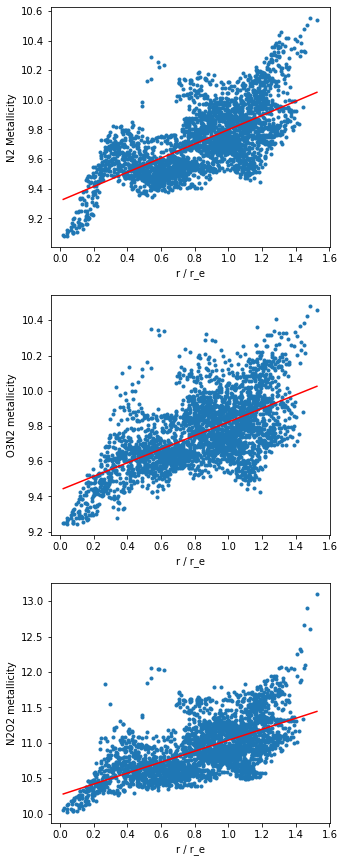

In [14]:
# # Calling the functions
# with fits.open('drpall-v2_4_3.fits', memmap=True) as drpall:
#     c_table = Table.read('DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_noWords_v5.txt',format='ascii.commented_header')
#     find_gradient('9487-12701',drpall[1].data,c_table)#('9487-12701',drpall[1].data,c_table)#('8335-12701')#('7443-12705')
# #     plt.savefig('PosterMaps/Scatter_8335-12701')

In [8]:
# with fits.open('MetallicityFITS/Brown_7992-12705.fits', mode='update') as hdul:
#     print(hdul.info())

Filename: MetallicityFITS/Brown_7992-12705.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   (0,)      
  1  N2_METALLICITY    1 ImageHDU         8   (74, 74)   float64   
  2  O3N2_METALLICITY    1 ImageHDU         8   (74, 74)   float64   
  3  N2O2_METALLICITY    1 ImageHDU         8   (74, 74)   float64   
  4  N2_IVAR       1 ImageHDU         8   (74, 74)   float64   
  5  O3N2_IVAR     1 ImageHDU         8   (74, 74)   float64   
  6  N2O2_IVAR     1 ImageHDU         8   (74, 74)   float64   
  7  N2_MASK       1 ImageHDU         8   (74, 74)   int32   
  8  O3N2_MASK     1 ImageHDU         8   (74, 74)   int32   
  9  N2O2_MASK     1 ImageHDU         8   (74, 74)   int32   
None
